# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [3]:
# Imports here....p
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# DONE: Write a function that LOAD CHECKPOINT and rebuilds the model
import torch
from torch import nn, optim              # for model classifier design & loss & optimiser choice
from torchvision import models           # to access a pre-trained model
import torchvision                       # required to re-create the architecture


def load_checkpoint(filename):
    '''
    Takes the filename/path of a checkpoint & loads 
    - the MODEL that created the checkpoint, &
    - the ASSOCIATED (WEIGHTS & BIASES) from the model's state_dict
    '''
    if torch.cuda.is_available():                        # to enable loading of the checkpoint when GPU not available
        map_location = lambda storage, loc: storage.cuda()   
    else:
        map_location='cpu'

    
    checkpoint = torch.load(filename, map_location=map_location)  # 1 - load 'checkpoint' dict from file, into memory
                                                                 # (look in appropriate map_location)   
    my_learn_rate = checkpoint['my_learn_rate'] 
    criterion = checkpoint['criterion'] 
    
    model = getattr(torchvision.models, checkpoint['architecture'])(pretrained=True) # KEY!!  
    model.fc = checkpoint['classifier']                                # these 2 lines instead of re-creation !!!
    
    model.load_state_dict(checkpoint['state_dict'])          # 3 - load the state_dict into the model's state_dict
    model.class_to_idx = checkpoint['class_to_idx']          # 3 - load mapping of classes to index into the model
    model.epochs = checkpoint['epochs']                      # 4 - load no epochs into model
    
    optimizer = optim.SGD(model.fc.parameters(), lr=my_learn_rate)  
    optimizer.load_state_dict(checkpoint['optimizer'])       # 4 - load optimizer's state_dict into memory
                    
    return model, optimizer


# load the checkpoint & have a look to see that it has correctly loaded
model, optimizer = load_checkpoint('./checkpoint1.pth')
print("Model is :", model)
print("Epochs are :", model.epochs)        
print("The optimizer state_dict :", optimizer)

Model is : ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [4]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [5]:
# TODO: Define your transforms for the training, validation, and testing sets
# TODO: Load the datasets with ImageFolder
# TODO: Using the image datasets and the trainforms, define the dataloaders

# DEFINE TRANSFORMS & LOAD IMAGES INTO DATASETS BY USING THESE TRANSFORMS
### TRAINING DATA....
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0), # Randomly change brightness/ contrast / saturation of an image.
    transforms.RandomHorizontalFlip(p=0.3),                                # Horiz. flip with prob. indicated
    transforms.RandomVerticalFlip(p=0.3),                                  # Vert. flip with prob. indicated
    transforms.RandomRotation((0, 360)),                                   # Rotate the image by angle between 0 & 360 degrees.
    transforms.RandomResizedCrop(224),                                     # Random crop down to size = (224*224)
    transforms.ToTensor(),                                               # tfm to a tensor...
    transforms.Normalize(mean=[0.485, 0.456, 0.406],                     # ??? these means & std's push my numbers out of scale 0..1?!
                         std=[0.229, 0.224, 0.225])                       # eg.  !!  (0-0.485)/0.229 = -2.11 !!!!!!
    ])                    # ...tfm tensor with means & std devns to normalise each channel of the input
# Normalising helps keep the network weights near zero which in turn makes backpropagation more stable. 
# Without normalization, networks will tend to fail to learn.  

train_set = datasets.ImageFolder(train_dir, transform=train_transforms) 
# gets data from training dir to be processed with the transforms 'train_transforms'
# (images are auto-labelled with the name of their directory)

### VALIDATION DATA....
valid_transforms = transforms.Compose([
    transforms.Resize(255),                                                # Resize to  (255*255)
    transforms.CenterCrop(224),                                            # Centre crop to size = (224*224)
    transforms.ToTensor(),                                                 # transform to a tensor..
    transforms.Normalize(mean=[0.485, 0.456, 0.406],                     # ??? these means & std's push my numbers out of scale 0..1?!
                         std=[0.229, 0.224, 0.225])                       # eg.  !!  (0-0.485)/0.229 = -2.11 !!!!!!
    ])
       
valid_set = datasets.ImageFolder(valid_dir, transform=valid_transforms) 
# gets data from validation dir to be processed with the transforms 'valid_transforms'
    
### TESTING DATA....
test_transforms = transforms.Compose([
    transforms.Resize(255),                                                # Resize to  (255*255)
    transforms.CenterCrop(224),                                            # Centre crop to size = (224*224)
    transforms.ToTensor(),                                                 # transform to a tensor...
    transforms.Normalize(mean=[0.485, 0.456, 0.406],                     # ??? these means & std's push my numbers out of scale 0..1?!
                         std=[0.229, 0.224, 0.225])                       # eg.  !!  (0-0.485)/0.229 = -2.11 !!!!!!
    ])
    
test_set = datasets.ImageFolder(test_dir, transform=test_transforms) 
# gets data from test dir to be processed with the transforms 'test_transforms'   

##  ---------------------------------------------------   
    
# DONE: LOAD THE DATASETS INTO DATALOADERS with ImageFolder
trainloader = torch.utils.data.DataLoader(train_set, batch_size=46, shuffle=True) # randomly shuffles for every epoch
# pass train_set to DataLoader which returns batches of images & corresponding labels - for TRAINING
    
validationloader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=True) # randomly shuffles for every epoch
# pass valid_set to DataLoader which returns batches of images & corresponding labels - for VALIDATION

testloader = torch.utils.data.DataLoader(test_set, batch_size=6, shuffle=True) # randomly shuffles for every epoch
# pass test_set to DataLoader which returns batches of images & corresponding labels - for TESTING

##  ---------------------------------------------------   


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
## load in a mapping from cat. no. to cat. name.  Held in file cat_to_name.json
## This provides a dict mapping the integer encoded categories to the actual names of the flowers
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name_dict = json.load(f)       # reading the dict into cat_to_name_dict  
cat_to_name = cat_to_name_dict
       
            
# Create a list of the 102 labels in label no. order
# (will be used as y_labels on the prob graph)

label_list = []

cat_to_name_dict = {int(k):str(v) for k,v in cat_to_name_dict.items()}   # make key an int so can be sorted properly
#print(cat_to_name_dict)

for key in sorted(cat_to_name_dict):                         # sort dict by key
    label_list.append(cat_to_name_dict[key])                 # append val to list
#print(label_list)                                           # correctly sorted now
label_list.insert(0,'not a flower>>>>>>>>')                  # add a {0 : 'not a flower'} option into the list
print(label_list, "\n\n")                                    # so, 103 final possible labels in label no order

# add 0 into dict
cat_to_name_dict[0] = 'not a flower>>>>>>>>'
print(cat_to_name_dict)                                      # the no. is now an int in the cat_to_name_dict
 

['not a flower>>>>>>>>', 'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'p

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [5]:
## DONE: BUILD & TRAIN MY NETWORK ##
from torchvision import models           # to access a pre-trained model
from torch import nn, optim              # for model classifier design & loss & optimiser choice
import time                              # for timing the training model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU access T-eed up
print("device is : ", device)

# I have needed to match the image normalisn used when the models were trained....
# (as per the means / std provided)  - which throws the rgb numbers out of range for matplotlib

# LOAD A PRE-TRAINED MODEL
model = models.resnet50(pretrained=True)     # has a 'features' component & a 'classifier' component
# think of trained networks as great feature detectors that can be used as input for simply feed-fwd classifiers
# this downloads the pretrained networks weights & biases as a starting pt for our model
# clearly, this will only serve us if our model can handle these


# FREEZE the 'FEATURES' PARAMETERS (we don't want these to get updated) & this speeds up training
for param in model.parameters():
    param.requires_grad = False    # turn off gradient calculation

# CREATE MY CLASSIFIER  (we want to REPLACE our 'classifier' with our own one ....)
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([            # naming my transforms & operations with OrderedDict()
    ('fc1', nn.Linear(2048, 1012)),                 # my model design of fully-connected layers
    ('relu1', nn.ReLU()),                            # starting with orig classifier's 'in_features=25088'?????too slow
    ('dropout1', nn.Dropout(p=0.2)),
    ('fc2', nn.Linear(1012, 512)),                 # my model design of fully-connected layers
    ('relu2', nn.ReLU()),                            # starting with orig classifier's 'in_features=25088'?????too slow
    ('dropout2', nn.Dropout(p=0.1)),
    ('fc3', nn.Linear(512, 103)),                  # 103 = no. of possible flower names (incl 1 for 'not a flower')
    ('output', nn.LogSoftmax(dim=1)),]))
model.fc = classifier                               # replace existing 'classifier' denoted "fc" in model defn, with mine

# select loss type; # select optimiser & learn rate
criterion = nn.NLLLoss()  
my_learn_rate = 0.15
optimizer = optim.SGD(model.fc.parameters(), lr=my_learn_rate)    
     
##  Training the model  ##
train_losses = []
val_losses = []
epochs = 8
model.to(device)                                        # move the processing to the GPU (if avail)
start = time.time()                                     # start a Training Loop timer

for e in range(epochs):
    
    running_loss = 0
    no_batches = 0
    print("Now training....")
    print("Starting Epoch no: {}".format(e+1))
    print("Learn rate : ",my_learn_rate)
    
    for images, labels in trainloader:                 # each step in the for loop == all images in a batch of training data
        optimizer.zero_grad()                          # Clear the gradients for each batch (else they accumulate)
        
        ### Training pass  ###  
        images, labels = images.to(device), labels.to(device)   # ensure images & labels are also moved to GPU
        logps = model(images)               # 1..4 FORWARD PASS (from nn) to get log probs (logsoftmax used)
        loss = criterion(logps, labels)     # 2..4 CALCULATE LOSS (from nn) used log probabilities
        loss.backward()                     # 3..4 BACKWARD PASS using our loss (this calcs gradients)  (from nn)
        optimizer.step()                    # 4..4 UPDATE WEIGHTS & BIASES based on the gradients & learn rate chosen (from optim)
        
        no_batches += 1
        running_loss += loss.item()                    # update the running loss by adding loss it
        
        if no_batches % 10 == 0:
            print("Training loss after {:3d} batches in epoch {}, is {:.3f}".format(no_batches, e+1, running_loss/no_batches))
        # at this stage ALL IMAGES (all batches) IN TRAINLOADER have been run through...
                
    else:       #  If no bk command in the for loop, then the else part will be called.
        print(f"Training loss: {e+1, running_loss/len(trainloader)}") 
        
        val_loss = 0
        accuracy = 0
        no_batches = 0
        print("Now validating after epoch ", e+1)
        
        with torch.no_grad():                            # turn off gradients for validation for speed/memory
            for images, labels in validationloader:      # for all 13 batches in the validation data
                images, labels = images.to(device), labels.to(device)   # ensure images & labels are also moved to GPU
                ### Validation pass  ###  
                logps = model(images)                   # FORWARD PASS to get log probs (logsoftmax used)
        
                no_batches += 1
                val_loss += criterion(logps, labels)    # calc & accumulate losses 
                ps = torch.exp(logps)                   # get the probabilities back from the log probs
        
                top_k, top_class = ps.topk(1, dim=1)    # get the predicted class no. of the highest prob into top_class
                # create a 'byte tensor' called equals where (top_class == labels)  {labels had shape (64) resized to be same as top_class shape}
                equals = top_class == labels.view(*top_class.shape)     # 'True' if predicted class matches true class
                accuracy += torch.mean(equals.type(torch.FloatTensor))  # mean does not work on a byte tensor...make equals a float tensor
                # torch.mean() returns a scalar tensor, to get the actual value as a float we'll need to do accuracy.item().
                print("Batch No. : {}".format(no_batches), "Test/validation Loss: {:.3f}".format(val_loss/no_batches),"Validation Accuracy: {:.2f}%".format(accuracy.item()*100/no_batches))
        
        train_losses.append(running_loss/len(trainloader))
        val_losses.append(val_loss/len(validationloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f} ".format(running_loss/len(trainloader)),
              "Test/validation Loss: {:.3f} ".format(val_loss/len(validationloader)),
              "Test/validation Accuracy: {:.2f}%".format(accuracy.item()*100/len(validationloader)))
        #print(train_losses)     # for testing
        #print(val_losses)       # for testing

            
    
stop = time.time()                                      # stop the Training/Validation Loop timer 
print("Total time training & validating (in seconds): ", (stop - start))
time_per_epoch = (stop - start)/epochs
print(f"Device is: {device}; Time per epoch: {time_per_epoch:.3f} seconds")  # print ave time/epoch 
time_per_batch = time_per_epoch/no_batches
print("Ave time per batch : ", time_per_batch, " in seconds.")




device is :  cuda


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 47927069.05it/s]


Now training....
Starting Epoch no: 1
Learn rate :  0.15
Training loss after  10 batches in epoch 1, is 4.604
Training loss after  20 batches in epoch 1, is 4.569
Training loss after  30 batches in epoch 1, is 4.524
Training loss after  40 batches in epoch 1, is 4.500
Training loss after  50 batches in epoch 1, is 4.469
Training loss after  60 batches in epoch 1, is 4.428
Training loss after  70 batches in epoch 1, is 4.384
Training loss after  80 batches in epoch 1, is 4.331
Training loss after  90 batches in epoch 1, is 4.309
Training loss after 100 batches in epoch 1, is 4.266
Training loss after 110 batches in epoch 1, is 4.223
Training loss after 120 batches in epoch 1, is 4.171
Training loss after 130 batches in epoch 1, is 4.127
Training loss after 140 batches in epoch 1, is 4.072
Training loss: (1, 4.052323786528794)
Now validating after epoch  1
Batch No. : 1 Test/validation Loss: 3.388 Validation Accuracy: 17.19%
Batch No. : 2 Test/validation Loss: 3.275 Validation Accuracy: 

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [11]:
# DONE: Do validation using the test set
import torch 
from torch import nn, optim              # for model classifier design & loss & optimiser choice

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU access T-eed up
print("device is : ", device)

# select loss type
criterion = nn.NLLLoss()  
       
##  Testing the model  with test data  ##
test_losses = []
model.to(device)                                                # move the processing to the GPU (if avail)
        
test_loss = 0
accuracy = 0
no_batches = 0
print("Now testing....")
        
with torch.no_grad():                                           # turn off gradients for testing - for speed/memory
    for images, labels in testloader:                           # for all <<819 batches>>  13 batches in the test data
        images, labels = images.to(device), labels.to(device)   # ensure images & labels are also moved to GPU
        ### Test pass  ###  
        logps = model(images)                    # FORWARD PASS to get log probs (logsoftmax used)
        
        no_batches += 1
        test_loss += criterion(logps, labels)    # calc & accumulate losses 
        ps = torch.exp(logps)                    # get the probabilities back from the log probs
        
        top_k, top_class = ps.topk(1, dim=1)     # get the predicted class of the highest probability into top_class()
        # these have len of batch size...print them 
        print("Batch no :", no_batches)
        print("Top class no's predicted for this batch : \n", top_class)        # for testing vis - remove later...
        #print("Top class's probability predicted for this batch : ", top_k)    # for testing vis - remove later...
        print("Correct label nos for this batch: ", labels)                     # for testing vis - remove later...
        
        # create a 'byte tensor' called equals where (top_class == labels)  {labels had shape (64) resized to be same as top_class shape}
        equals = top_class == labels.view(*top_class.shape)     # 'True' if predicted class matches true class
        #print(equals)
        accuracy += torch.mean(equals.type(torch.FloatTensor))  # mean does not work on a byte tensor...make equals a float tensor
        # torch.mean() returns a scalar tensor, to get the actual value as a float we'll need to do accuracy.item().
        print("Batch No. : {}".format(no_batches), 
              "Running Test Loss over batches so far: {:4.2f} ".format(test_loss/no_batches),
              "Running Test Accuracy over batches so far: {:1.1f}%".format(accuracy.item()*100/no_batches))
        print("Correct label nos for the batch: ", labels)      # Correct label nos for the batch
        print("\n")
                 
            
    print("Overall Test Loss for this data set: {:.2f}.. ".format(test_loss/len(testloader)), 
          "Overall Test Accuracy for this data set: {:.1f}%".format(accuracy.item()*100/len(testloader)))
    
    test_losses.append(test_loss/len(testloader))
    print(test_losses)
 
      

device is :  cpu
Now testing....
Batch no : 1
Top class no's predicted for this batch : 
 tensor([[ 13],
        [ 77],
        [ 73],
        [ 96],
        [ 98],
        [ 21]])
Correct label nos for this batch:  tensor([ 13,  77,  73,  35,  98,   4])
Batch No. : 1 Running Test Loss over batches so far: 1.18  Running Test Accuracy over batches so far: 66.7%
Correct label nos for the batch:  tensor([ 13,  77,  73,  35,  98,   4])


Batch no : 2
Top class no's predicted for this batch : 
 tensor([[ 17],
        [ 84],
        [ 99],
        [ 24],
        [ 73],
        [ 49]])
Correct label nos for this batch:  tensor([ 17,  84,  44,  24,  73,  26])
Batch No. : 2 Running Test Loss over batches so far: 1.34  Running Test Accuracy over batches so far: 66.7%
Correct label nos for the batch:  tensor([ 17,  84,  44,  24,  73,  26])


Batch no : 3
Top class no's predicted for this batch : 
 tensor([[ 34],
        [ 49],
        [ 49],
        [ 75],
        [ 43],
        [ 74]])
Correct l

KeyboardInterrupt: 

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [7]:
# Review the model before saving a checkpoint
print("The model for which I am considering saving a checkpoint, is : \n\n", model)
print("The associated state_dict, is held in model.state_dict()'\n\n")
print("The keys from model.state_dict() are: \n")

for key in model.state_dict():     # have a look at the model.state_dict() keys
    print(key)

print("\n\n The associated optimiser state, is held in optimiser.state_dict()'\n\n")
print("The keys from optimiser.state_dict() are: \n")
for key in optimizer.state_dict():     # have a look at the optimiser.state_dict() keys
    print(key)
# ________________________________________________________________________________
print("____________________________________________________________________")


#  DONE: SAVE THE CHECKPOINT  #
# When we load the weights & biases from the state_dict, we need to input these into a model 
# which is identical to that which created the w&b's in the first place.
# So, it makes sense to save a checkpoint which contains not only the w&b's but also the model architecture.


# 1..2 CREATE THE CHECKPOINT - { a dict of (the model arch. & the state_dict (containing the weights & biases)) }
# !!  Ensure you setup the checkpoint model arch. to mirror that of the model you wish to save !!
model.class_to_idx = test_set.class_to_idx   # a mapping of classes to indices   (taking the test_set)

checkpoint = {'input_size' : 2048,
              'fc1' : 1012,
              'fc2' : 512,
              'fc3' : 103,
              'output_size' : 103,
              'architecture' : 'resnet50',          # saving this means that you dont need to re-load the model from torchvision models later
              'state_dict' : model.state_dict(),
              'optimizer' : optimizer.state_dict(),
              'classifier' : classifier,
              'epochs' : 16,
              'my_learn_rate' : 0.15,
              'criterion' : 'nn.NLLLoss()',
              'class_to_idx': model.class_to_idx     # mapping of classes to index
             }

# 2..2 SAVE THE CHECKPOINT to file checkpoint1.pth in current dir
torch.save(checkpoint, './checkpoint1.pth')
print("saved...")


The model for which I am considering saving a checkpoint, is : 

 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
    

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [1]:
# DONE: Write a function that loads a checkpoint and rebuilds the model
import torch
from torch import nn, optim              # for model classifier design & loss & optimiser choice
from torchvision import models           # to access a pre-trained model
import torchvision                       # required to re-create the architecture


def load_checkpoint(filename):
    '''
    Takes the filename/path of a checkpoint & loads 
    - the MODEL that created the checkpoint, &
    - the ASSOCIATED (WEIGHTS & BIASES) from the model's state_dict
   '''
    # Load the checkpoint data to the best currently available location
    if torch.cuda.is_available():                        # to enable loading of the checkpoint when GPU not available
        map_location = lambda storage, loc: storage.cuda()   
    else:
        map_location='cpu'

    
    checkpoint = torch.load(filename, map_location=map_location)  # 1 - load 'checkpoint' dict from file, into memory
                                                                 # (look in appropriate map_location)
    
        
        
        
    my_learn_rate = checkpoint['my_learn_rate'] 
    criterion = checkpoint['criterion'] 
    
    model = getattr(torchvision.models, checkpoint['architecture'])(pretrained=True) # KEY!!  
    model.fc = checkpoint['classifier']                                # these 2 lines instead of re-creation !!!
    
    model.load_state_dict(checkpoint['state_dict'])          # 3 - load the state_dict into the model's state_dict
    model.class_to_idx = checkpoint['class_to_idx']          # 3 - load mapping of classes to index into the model
    model.epochs = checkpoint['epochs']                      # 4 - load no epochs into model
    
    optimizer = optim.SGD(model.fc.parameters(), lr=my_learn_rate)  
    optimizer.load_state_dict(checkpoint['optimizer'])       # 4 - load optimizer's state_dict into memory
                    
    return model, optimizer


# load the checkpoint & have a look to see that it has correctly loaded
model, optimizer = load_checkpoint('./checkpoint1.pth')
print("Model is :", model)
print("Epochs are :", model.epochs)        
print("The optimizer state_dict :", optimizer)
    

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 119183862.49it/s]


Model is : ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

the BEFORE image
the AFTER image
(224, 224, 3)
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ..., 
 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
Mean: 77.462, Standard Deviation: 84.539


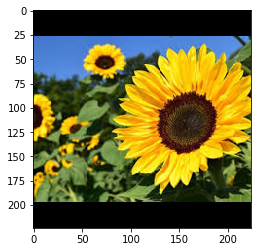

In [19]:
# TODO: Process a PIL image for use in a PyTorch model

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def process_image(image):
    # Scales, crops, and normalizes a PIL image for a PyTorch model,
    # returns an Numpy array
    
    size = 256, 256
    image.thumbnail(size)                          # resize with shortest side 256, preserving existing aspect ratio
    
    width, height = image.size                     # Get dimensions & centre crop to 224*224
    req_width = 224                                # co-ords are based on a cartn. plain with top left = (0, 0)
    req_height = 224                               # calculate the numbers for left/top/right/bottom
    left = (width - req_width)/2
    top = (height - req_height)/2
    right = (left + req_width)
    bottom = (top + req_height)

    # Crop the center of the image                          # 'left' = top left x; 'top' = top left y;
    image = image.crop((left, top, right, bottom))  #  'right' = bottom right x; 'bottom' = bottom right y
  
    # Convert to a NUMPY array & normalise the RGB channels
    image = np.array(image)
    image = image/255.                   
    mean = np.array([0.485, 0.456, 0.406])
    sd = np.array([0.229, 0.224, 0.225])
    image = ((image - mean) / sd)
    image = np.transpose(image, (2, 0, 1)) 
    
    return image

#_____________________________________________________________________________
print("the BEFORE image")
im = Image.open("sunflower_01.jpg")
plt.imshow(im)                              
plt.show


# Process the image & print it
pd_image = process_image(im)
print("the AFTER image")
plt.imshow(pd_image)  
plt.show
print(pd_image.shape)            # shape (224, 224, 3)
print(pd_image)


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [ ]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [40]:
# TODO: Implement the code to predict the class from an image file
from torchvision import datasets, transforms
import matplotlib.pyplot as plt  # for visualisations   
%matplotlib inline  

def predict(image_path, model, labels_dict, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''    
    
    with torch.no_grad():                            # turn off gradients for prediction - for speed/memory
        logps = model(image_path)                    # FORWARD PASS to get log probs (logsoftmax used)
    ps = torch.exp(logps)                            # get the probabilities back from the log probs
    print("Ps are: expect 103 ", ps)
        
    top_k, top_class = ps.topk(5, dim=1)             # get the 5 highest predicted classes into tensor [top_class]
                                                     # & get the 5 highest probs into tensor [top_k]
    
    print("top class is :",top_class )
    y_labels = []                                    # get the labels for the 5 - for use on the y-axis of the prob graph
    top_class_list = top_class.tolist()              # top_class_list is like a list within a list...
    clean_top_class_list = top_class_list[0]                    # ...peeling the onion
    print("clean_top_class_list : ",clean_top_class_list)
        
    for num in clean_top_class_list:
        y_labels.append(labels_dict[num])            # y-labels now contains top 5 descriptions
    print("y_labels:   ", y_labels)    
         
            
            
    plt.figure(figsize = [8, 6])  # creates new Fig, 3" by 6"  (overall size for both plots)
    image_path.squeeze_(0)                # Remove the first dim (the batch that we added to get this through FWD PASS)
    print("Shape     ", image_path.shape)
    pic = image_path.permute(1, 2, 0)  # change the order dim[1], foll'd by dim[2] then dim[0] for matplotlib to accept it
    
    plt.subplot(1, 2, 1)          # first subplot: divide the fig into a 1 by 2 (# Note: slot index numbers start at 1 (not 0). )
    plt.imshow(pic)               # show pic
   
    plt.subplot(1, 2, 2)          # second subplot: divide the fig into a 1 by 2 (# & this is slot 2..2)
    plt.xticks(rotation=45)
    
    top_k_list = top_k.tolist()                         # [[top_k_list]] is like a list within a list...
    clean_top_k_list = top_k_list[0]                    # ...peeling the [onion]
    print("clean_top_k_list:   ", clean_top_k_list)
    
    plt.bar(y_labels, clean_top_k_list)
    plt.show()
    
    return clean_top_k_list, clean_top_class_list
    
#___________________________________________________________________________________________________
# Get an image in a tensor format - an image FROM THE VALIDN DIR IN THE LOADER
valid_transforms = transforms.Compose([
    transforms.Resize(255),                                                # Resize to  (255*255)
    transforms.CenterCrop(224),                                            # Centre crop to size = (224*224)
    transforms.ToTensor(),                                                 # transform to a tensor..
    ])
       
valid_set = datasets.ImageFolder('flowers/valid', transform=valid_transforms) 
# gets data from validation dir to be processed with the transforms 'valid_transforms'

validationloader = torch.utils.data.DataLoader(valid_set, batch_size=3, shuffle=True) # randomly shuffles for every epoch
# pass valid_set to DataLoader which returns batches of images & corresponding labels - for VALIDATION

#data_iter = iter(validationloader)        # make the loader iterable
#images, labels = next(data_iter)          # get first batch of images & labels
chosen_image = valid_set[0]                 # 1st image in the batch                            ????? Correct????

print("image shape before unsqueezed: ", chosen_image.shape)      # shape is (3, 244, 244)
#chosen_image.unsqueeze_(0)                # adding a batch dimension else trps up on 'stride size'
#print("image shape after unsqueeze & when sent to fn :", chosen_image.shape)  
# shape is (1, 3, 244, 244)   ... we need this shape to run .model()
        
       
probs, classes = predict(chosen_image, model, labels_dict)  # arg-1 must be a tensor
print("Probs: ", probs)
print("Classes :", classes)
print("The correct label is: ", labels[0].item())
print("The correct descrip is :", labels_dict[labels[0].item()])



AttributeError: 'tuple' object has no attribute 'shape'

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
# TODO: Display an image along with the top 5 classes

In [64]:
# DONE: Sanity test using the few images I have added

from torchvision import models           # to access a pre-trained model
#from torch import nn, optim              # for model classifier design & loss & optimiser choice
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU access T-eed up
print("device is : ", device)
model.to(device)                                        # move the processing to the GPU (if avail)

      
##  Testing the model with single image  ##
               
im = Image.open("sunflower_01.jpg")
# Process the image
pd_image = process_image(im)
print("the AFTER image")
plt.imshow(pd_image)  
plt.show

im = pd_image.to(device)                          # ensure image also moved to GPU
            
#image_path = images[0]
#image_path.unsqueeze_(0)
#logps = model(image_path)                        # FORWARD PASS to get log probs (logsoftmax used)
#image_path.squeeze_(0) 
            
logps = model(im)
#ps = torch.exp(logps)                            # get the probabilities back from the log probs
top_k, top_class = ps.topk(5, dim=1)              # get the 5 highest predicted classes into tensor [top_class]
                                                  # & get the 5 highest prob'abilities' into tensor [top_k]
y_labels = []                                     # get the labels for the 5 - for use on the y-axis of the prob graph
top_class_list = top_class.tolist()               # top_class_list is like a list within a list...
clean_top_class_list = top_class_list[0]          # ...peeling the onion
print("clean_top_class_list : ",clean_top_class_list)
        
for num in clean_top_class_list:
    y_labels.append(cat_to_name_dict[num])            # y-labels now contains top 5 descriptions
print("y_labels:   ", y_labels)    
            
plt.figure(figsize = [8, 6])  # creates new Fig, 3" by 6"  (overall size for both plots)
                           # Remove the first dim (the batch that we added to get this through FWD PASS)
print("Shape     ", image_path.shape)
pic = image_path.permute(1, 2, 0)  # change the order dim[1], foll'd by dim[2] then dim[0] for matplotlib to accept it
    
plt.subplot(1, 2, 1)          # first subplot: divide the fig into a 1 by 2 (# Note: slot index numbers start at 1 (not 0). )
plt.imshow(pic)               # show pic
   
plt.subplot(1, 2, 2)          # second subplot: divide the fig into a 1 by 2 (# & this is slot 2..2)
plt.xticks(rotation=45)
    
top_k_list = top_k.tolist()                         # [[top_k_list]] is like a list within a list...
clean_top_k_list = top_k_list[0]                    # ...peeling the [onion]
print("clean_top_k_list:   ", clean_top_k_list)
    
plt.bar(y_labels, clean_top_k_list)
plt.show()
        
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        

device is :  cpu


NameError: name 'Image' is not defined

In [65]:
# DONE: SANITY CHECK - USING DATA FROM TEST LOADER !!!!!!!!

from torchvision import models           # to access a pre-trained model
#from torch import nn, optim              # for model classifier design & loss & optimiser choice
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU access T-eed up
print("device is : ", device)
model.to(device)                                        # move the processing to the GPU (if avail)

      
##  Testing the model with SINGLE IMAGE  ##                         
logps = model(im)
#ps = torch.exp(logps)                            # get the probabilities back from the log probs
top_k, top_class = ps.topk(5, dim=1)              # get the 5 highest predicted classes into tensor [top_class]
                                                  # & get the 5 highest prob'abilities' into tensor [top_k]
y_labels = []                                     # get the labels for the 5 - for use on the y-axis of the prob graph
top_class_list = top_class.tolist()               # top_class_list is like a list within a list...
clean_top_class_list = top_class_list[0]          # ...peeling the onion
print("clean_top_class_list : ",clean_top_class_list)
        
for num in clean_top_class_list:
    y_labels.append(cat_to_name_dict[num])            # y-labels now contains top 5 descriptions
print("y_labels:   ", y_labels)    
            
plt.figure(figsize = [8, 6])  # creates new Fig, 3" by 6"  (overall size for both plots)
                           # Remove the first dim (the batch that we added to get this through FWD PASS)
print("Shape     ", image_path.shape)
pic = image_path.permute(1, 2, 0)  # change the order dim[1], foll'd by dim[2] then dim[0] for matplotlib to accept it
    
plt.subplot(1, 2, 1)          # first subplot: divide the fig into a 1 by 2 (# Note: slot index numbers start at 1 (not 0). )
plt.imshow(pic)               # show pic
   
plt.subplot(1, 2, 2)          # second subplot: divide the fig into a 1 by 2 (# & this is slot 2..2)
plt.xticks(rotation=45)
    
top_k_list = top_k.tolist()                         # [[top_k_list]] is like a list within a list...
clean_top_k_list = top_k_list[0]                    # ...peeling the [onion]
print("clean_top_k_list:   ", clean_top_k_list)
    
plt.bar(y_labels, clean_top_k_list)
plt.show()
        
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        

device is :  cpu


NameError: name 'im' is not defined

device is :  cpu
The model.class_idx...
{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95':

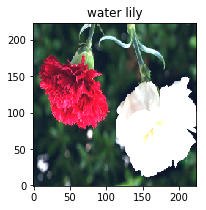

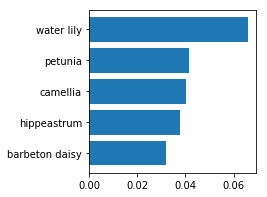

In [20]:
# SOLN 7th Oct   
# back to this crop on first advice in the process_image - creates a correct pic but incorrect probabilities
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from pylab import *
#__________________________________________________________________
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
      
    image = image.resize((256,256)) 
    cr = 0.5*(256-224)
    image = image.crop((cr, cr, 256-cr, 256-cr))
    image = np.array(image)
    image = image/255.                   
    mean = np.array([0.485, 0.456, 0.406])
    sd = np.array([0.229, 0.224, 0.225])
                       
    image = ((image - mean) / sd)
    image = np.transpose(image, (2, 0, 1)) 
    return image

#ctx = model.class_to_idx     

#___________________________________________________________________
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to PREDICT THE CLASS FROM AN IMAGE FILE
    

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU access T-eed up
    print("device is : ", device)  
    model.to(device) 
     
    img_torch = Image.open(image_path)        # open the image into a PIL.JPEG
    img_torch = process_image(img_torch)      # process the image with our fn - which returns a Numpy array
    img_torch = torch.from_numpy(img_torch)   # change ndarray to tensor
    img_torch = img_torch.unsqueeze_(0)       # add batch dimension to tensor
    img_torch = img_torch.float()             # convert values in tensor to float
    
    img_torch.to(device)
    
    with torch.no_grad():
        output = model.forward(img_torch) # use cuda - FORWARD PASS!!!!!  output = model.forward(img_torch.cuda())
           
    probability = F.softmax(output.data,dim=1)         # use F to get all the probs
    
    probs = np.array(probability.topk(topk)[0][0])     # extract just the top 5 probs
    
    print("The model.class_idx...")
    print(model.class_to_idx)
    
    index_to_class = {val: key for key, val in model.class_to_idx.items()} # from reviewer advice
    print("The idx_ti_class... should just have key:val swapped around")
    print( index_to_class)
    
    
    #top_classes = [np.int(index_to_class[each]) for each in np.array(probability.topk(topk)[1][0])]
    
    #I get the same lookups as the two lines above - with this technique...?!>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    top_classes = np.array(probability.topk(topk)[1][0])     # extract just the top 5 c's
    print(top_classes)   # before the indx lookup
    
    # lookup the actual class number...
    top_classes = [np.int(index_to_class[each]) for each in top_classes]
    print(top_classes)  # after the inx lookup
    
    
    # for visibility while testing.....
    for key, value in sorted(cat_to_name.items(), key=lambda x: x[0]): #??????????????
        print("{} : {}".format(key, value))
  
    
    for num in top_classes:
        top_label = cat_to_name[str(num)]
        print(top_label)
   
    #y = cat_to_name[str(1)]
    #print("Y is", y)
    
    
    # Get correct label name
    # process the path string to get the dir_num (which will be used to lookup the correct label y)
   # dir_num = int(image_path.split('/')[-2])            # gets the directory number
   # print(dir_num)
   
    '''
    correct_class_code = index_to_class[dir_num]   # looking up the the image's correct class code with dir_num
    print(correct_class_code)
    '''

    # getting the image's correct label
   # y = cat_to_name[str(dir_num)]      # looking up the image's correct label name (y) with correct_class_code
   # print("Correct Label Name, is :", y)

    return probs, top_classes
#___________________________________________________________________

# TODO: Display an image along with the top 5 classes ###############
    
path = ('flowers/test/31/image_06903.jpg')    # carnation test

plt.figure(figsize=(3,3))
#plt.subplot(211)
probs, classes = predict(path, model)        # run the PREDICT Fn - (yields top5 probs & top5 classes)

image = process_image(Image.open(path))      # need to open with PIL first
                                            
max_index = classes[0]                       # get the top prob class no. (being the 1st one) - a string


# To make the image PRINTABLE through matplotlib... image values are tween -2ish to 2ish...needs to be 0-1 for matplotlib
#print(image.shape)                           # image shape is (3, 224, 224) & matplotlib needs it with RGB at end
image = image.transpose(1,2,0)
#print(image.shape)  
#print(image) 
mean, std = image.mean(), image.std()
image = (image - mean) / std                # global standardization of pixels
image = clip(image, -1.0, 1.0)              # clip pixel values to [-1,1]
image = (image + 1.0) / 2.0                 # shift from [-1,1] to [0,1] with 0.5 mean
mean, std = image.mean(), image.std()       # confirm it had the desired effect
print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
print('Min: %.3f, Max: %.3f' % (image.min(), image.max()))


axs = imshow(image, origin = [1,1])

#axs.axis('off')
plt.title(cat_to_name[str(max_index)])       # The predicted class name
#axs.show()

# following graph is adapted from https://matplotlib.org/gallery/lines_bars_and_markers/barh.html
plt.figure(figsize=(3,3))
#plt.subplot(212)

names = [cat_to_name[str(index)] for index in classes]  # label names for y-axis
y_pos = np.arange(len(names))
performance = np.array(probs)
plt.barh(y_pos, performance, align='center')
plt.yticks(y_pos, names)
plt.gca().invert_yaxis()                               # labels read top-to-bottom
# The gcf() fn used to get the current Axes instance on the current figure matching the given keyword args, or create one.

#print(model.class_to_idx)
